In [1]:
import numpy as np
import pandas as pd
import vmlab

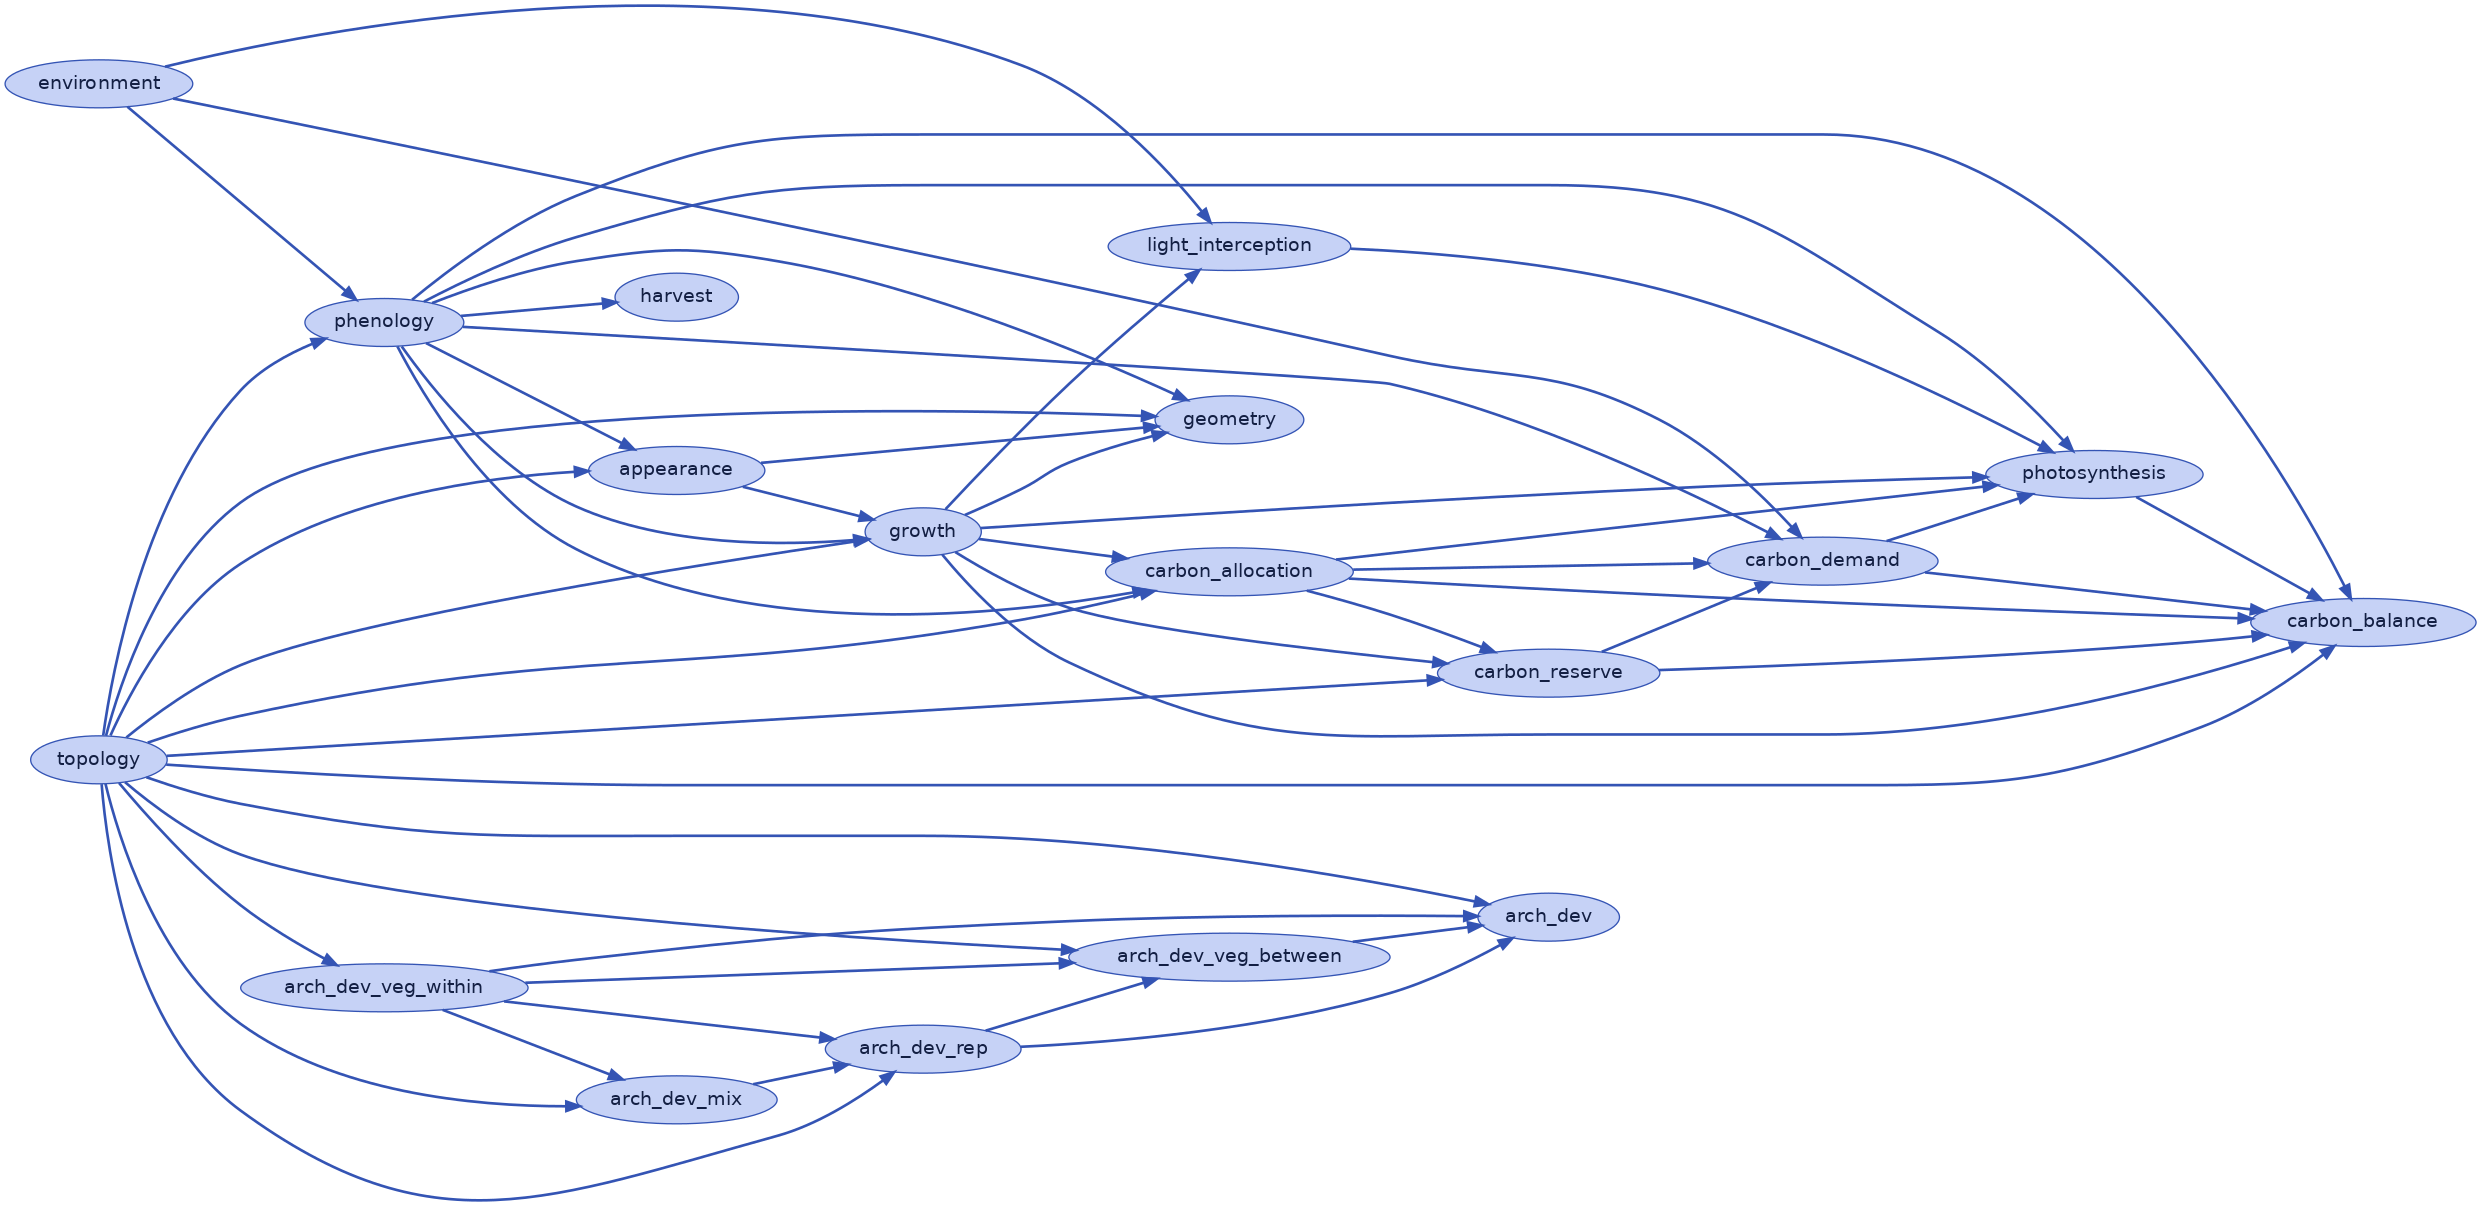

In [2]:
from vmlab.models import vmango
vmango.visualize()

In [3]:
start_date='2003-06-01'
end_date='2005-06-01'
setup = vmlab.create_setup(
    model=vmango,
    start_date=start_date,
    end_date=end_date,
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'geometry__interpretation_freq': 14
    },
    output_vars=None
)

In [4]:
ds_out = vmlab.run(setup, vmango, geometry=True)

SceneWidget(scenes=[{'id': 'xqlp2rcKDPXWJmxu0KmeritD0', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 